# Nations and Conflict

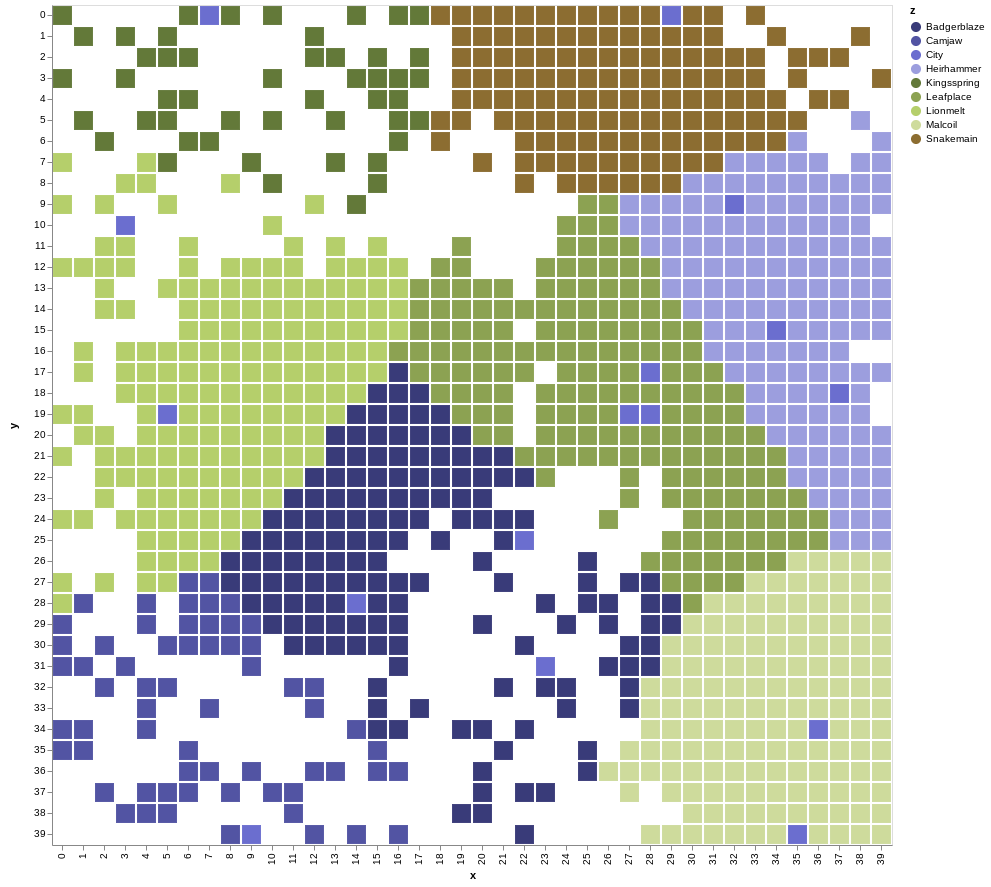

In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt
#only using yaml for it's pretty printing feature. 
import yaml

# importing local libraries for drawings (because they clutter)
# in Github, you can search  
#   They should still be available within the git repo but it's pretty much template stuff from altair
import sys
sys.path.append('../')
from lib.builders import towns,nations,people
import lib.drawMaps as draw

with (open('world_2.p', 'rb')) as pickle_file:
    world = pickle.load(pickle_file)
    
draw.drawboarders(world.df_features)

Now that we have `landscape`, `culture`, `nations`, `towns`, and `people` we can start building an interaction between them. 

We can start with a `world` that has `nations` and each `Nation` has `towns`. 

In [2]:
world.towns

[capitol of Solhaven: population: 4 location: [23,31] founded 0,
 town of Lilykeep: population: 4 location: [5,19] founded 0,
 capitol of Snakelight: population: 4 location: [28,17] founded 1,
 capitol of Ravenblaze: population: 6 location: [3,10] founded 1,
 capitol of Fenvale: population: 4 location: [36,34] founded 1,
 town of Helljaw: population: 3 location: [28,19] founded 2,
 capitol of Brinemore: population: 5 location: [34,15] founded 2,
 town of Fallring: population: 4 location: [37,18] founded 3,
 town of Stormgarden: population: 4 location: [32,9] founded 4,
 town of Lilymoral: population: 2 location: [22,25] founded 4,
 capitol of Gleamvale: population: 3 location: [9,39] founded 5,
 capitol of Splithenge: population: 2 location: [29,0] founded 5,
 town of Leafmoral: population: 2 location: [14,28] founded 6,
 town of Founderscombe: population: 1 location: [35,39] founded 8,
 town of Heirbridge: population: 2 location: [27,19] founded 8,
 capitol of Ravenfellow: population:

In [3]:
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Lilykeep is loyal to the nation of Lionmelt
{'nation': 'Lionmelt', 'national fealty': 1}


In [4]:
world.nations

[Nation of Lionmelt,
 Nation of Badgerblaze,
 Nation of Snakemain,
 Nation of Malcoil,
 Nation of Heirhammer,
 Nation of Camjaw,
 Nation of Leafplace,
 Nation of Kingsspring]

In [5]:
example_nation = world.nations[1]
print (example_nation.ruler," has a temperment of ",example_nation.ruler.temperment)
print (example_nation.get_capitol().speaker," has a loyalty of ",example_nation.get_capitol().speaker.loyalty)

Eliggark, Ruler of the nation of Badgerblaze, residing in Solhaven  has a temperment of  0.24625056659187805
Chifaddort, Speaker of Solhaven, residing in Solhaven  has a loyalty of  0.5


In [6]:
example_nation.towns

[capitol of Solhaven: population: 4 location: [23,31] founded 0,
 town of Lilymoral: population: 2 location: [22,25] founded 4,
 town of Leafmoral: population: 2 location: [14,28] founded 6]

## Swaying favor with other nations

Events cause the relationship to sway between nations. This can be done by passing the `nation` or list of `nation` objects into the `alter_favor` function. 

In [7]:
nations.treaties

,stance,favor
0,sworn enemies,0.0
1,war,0.1
2,tense,0.3
3,peace,0.6
4,allies,0.9


In [8]:
help(nations.alter_favor)

Help on function alter_favor in module lib.builders.nations:

alter_favor(s, o, a)
    s = the target nation(s) (obj or list). s will not change. O's favor of s will change.
    o = the nation(s) (obj or list) who's favor is change. O's favor of s will change
    
    Examples:
    (a,[o]) each nation in o's favor of a is changed by s
    (a,o) o's favor of a is changed by s
    ([a],o) o's favor of each nation in a is changed by s
    s = amount of change (int)
    
    national relationship with itself doesn't decay, but town and person loyalty can.



### example 1: one nation does something that many other nations's don't like. 

In [9]:
s_nation = world.nations[0]
o_nations = world.nations[1:3]
affect = -.25
nations.alter_favor(s_nation,o_nations,affect)

In [10]:
print("subject nations (nations who have done the deed)")
print(f"{s_nation} did something {affect} to {o_nations}")
print(s_nation,"\n",yaml.dump(s_nation.diplomacy))

print("object nations (nations who's favor is affected by the deed)")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in o_nations]


subject nations (nations who have done the deed)
Nation of Lionmelt did something -0.25 to [Nation of Badgerblaze, Nation of Snakemain]
Nation of Lionmelt 
 Badgerblaze:
  favor: 0.8
  stance: peace
Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Malcoil:
  favor: 0.8
  stance: peace
Snakemain:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Badgerblaze 
 Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Lionmelt:
  favor: 0.55
  stance: tense
Malcoil:
  favor: 0.8
  stance: peace
Snakemain:
  favor: 0.8
  stance: peace

Nation of Snakemain 
 Badgerblaze:
  favor: 0.8
  stance: peace
Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  f

[None, None]

### example 2: several nations does something that annother nation likes. 

In [11]:
s_nations = world.nations[2:4]
o_nation = world.nations[5]
affect = .25

nations.alter_favor(s_nations,o_nation,affect)

In [12]:
print("subject nations (nations who have done the deed)")
print(f"{s_nations} did something {affect} to {o_nation}")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in s_nations]
print("object nations (nations who's favor is affected by the deed)")
print(o_nation,"\n",yaml.dump(o_nation.diplomacy))

subject nations (nations who have done the deed)
[Nation of Snakemain, Nation of Malcoil] did something 0.25 to Nation of Camjaw
Nation of Snakemain 
 Badgerblaze:
  favor: 0.8
  stance: peace
Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Lionmelt:
  favor: 0.55
  stance: tense
Malcoil:
  favor: 0.8
  stance: peace

Nation of Malcoil 
 Badgerblaze:
  favor: 0.8
  stance: peace
Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Lionmelt:
  favor: 0.8
  stance: peace
Snakemain:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Camjaw 
 Badgerblaze:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Lionmelt:
  favor: 0.

Events are thier own thing. They aren't `culture` or `landscape`. They only happen in the begging of the game to add dynamics to the world. 

In [16]:
events = pd.read_csv('../lib/Datasets/events.csv',index_col=0)
events

,n_subjects,n_objects,event,effect_var,effect
raiders,1,3,"raiders from {a}, plundered {o}",favor,-0.15
marrage,1,1,a princess from {o} was married to {a},favor,0.3
temple,1,0,a great temple was founded in the nation of {a},buildings,temple


In [17]:
world.culture.eons,world.culture.chaos

(10, 0.6)

In [26]:
def event_results(events,nations,verbose=True):
    """

    """
    choice = np.random.choice(events.index)
    event = events.loc[choice]
    a = np.random.choice(world.nations,event.n_subjects,replace=False).tolist()
    o = np.random.choice(world.nations,event.n_objects,replace=False).tolist()
    if event.effect_var == 'favor':
        nations.alter_favor(a,o,float(event.effect))
    text = (event.event.replace('{o}',str(o)).replace('{a}',str(a))) 
    if verbose:   
        print(text)
    return text
    
#now to run through the eons and let fate happen
for e in range(world.culture.eons):
    if np.random.random_sample()<world.culture.chaos:
        event_results(events,nations)
    else:
        print(f'{e}: nothing happend during this period.')

a great temple was founded in the nation of [Nation of Lionmelt]
1: nothing happend during this period.
raiders from [Nation of Lionmelt], plundered [Nation of Malcoil, Nation of Snakemain, Nation of Camjaw]
a princess from [Nation of Kingsspring] was married to [Nation of Leafplace]
raiders from [Nation of Malcoil], plundered [Nation of Leafplace, Nation of Malcoil, Nation of Heirhammer]
5: nothing happend during this period.
6: nothing happend during this period.
raiders from [Nation of Kingsspring], plundered [Nation of Snakemain, Nation of Kingsspring, Nation of Badgerblaze]
8: nothing happend during this period.
raiders from [Nation of Malcoil], plundered [Nation of Malcoil, Nation of Badgerblaze, Nation of Snakemain]


In [34]:
print("Ending relationships between nations")
for j in world.nations:
    print(j,"\n",yaml.dump(j.diplomacy))

Ending relationships between nations
Nation of Lionmelt 
 Badgerblaze:
  favor: 0.8
  stance: peace
Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.8
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Malcoil:
  favor: 0.8
  stance: peace
Snakemain:
  favor: 0.8
  stance: peace

Nation of Badgerblaze 
 Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.65
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Lionmelt:
  favor: 0.55
  stance: tense
Malcoil:
  favor: 0.65
  stance: peace
Snakemain:
  favor: 0.8
  stance: peace

Nation of Snakemain 
 Badgerblaze:
  favor: 0.65
  stance: peace
Camjaw:
  favor: 0.8
  stance: peace
Heirhammer:
  favor: 0.8
  stance: peace
Kingsspring:
  favor: 0.65
  stance: peace
Leafplace:
  favor: 0.8
  stance: peace
Lionmelt:
  favor: 0.4
  stance: tense
Malcoil:
  favor: 0.65
  stance: peace

Nation of Malcoil 
 Badgerblaze:
  favor: 0.65
  st